In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2_contingency, linregress


df = pd.read_csv('auto-mpg.csv', na_values='?')
mask = df.columns.isin(['mpg', 'horsepower', 'weight', 'acceleration'])
#grr = pd.plotting.scatter_matrix(df.loc[:, mask], figsize=(15, 15), marker='o',
#                                 hist_kwds={'bins': 20}, s=60, alpha=.8)
df.loc[:, mask].corr()
df.dropna(inplace=True)
df['model year'] = df['model year'] + 1900
print(df.info())

cols = df['mpg'], df['horsepower'], df['weight'], df['acceleration']
print(' '*17, end='')
for col1 in cols:
    print(f'{col1.name:^25}', end='')
print()

for col0 in cols:
    print(f'{col0.name:15}|', end='  ')
    for col1 in cols:
        if col0 is col1:
            print(' '*25, end='')
            continue
        regr = linregress(col0, col1)
        print('{:7.3f}, {:5.3f}, {:5.3f}'.format(regr.slope/regr.stderr, regr.rvalue**2, regr.pvalue), end='    ')
        #print(pearsonr(col0, col1), end=' ')
    print()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB
None
                            mpg                  horsepower                 weight                acceleration       
mpg            |                           -24.489, 0.606, 0.000    -29.645, 0.693, 0.000      9.228, 0.179, 0.000    
horsepower     |  -24.489, 0.606, 0.000                              33.972, 0.747, 0.000    -18.784, 0.475, 0.000    

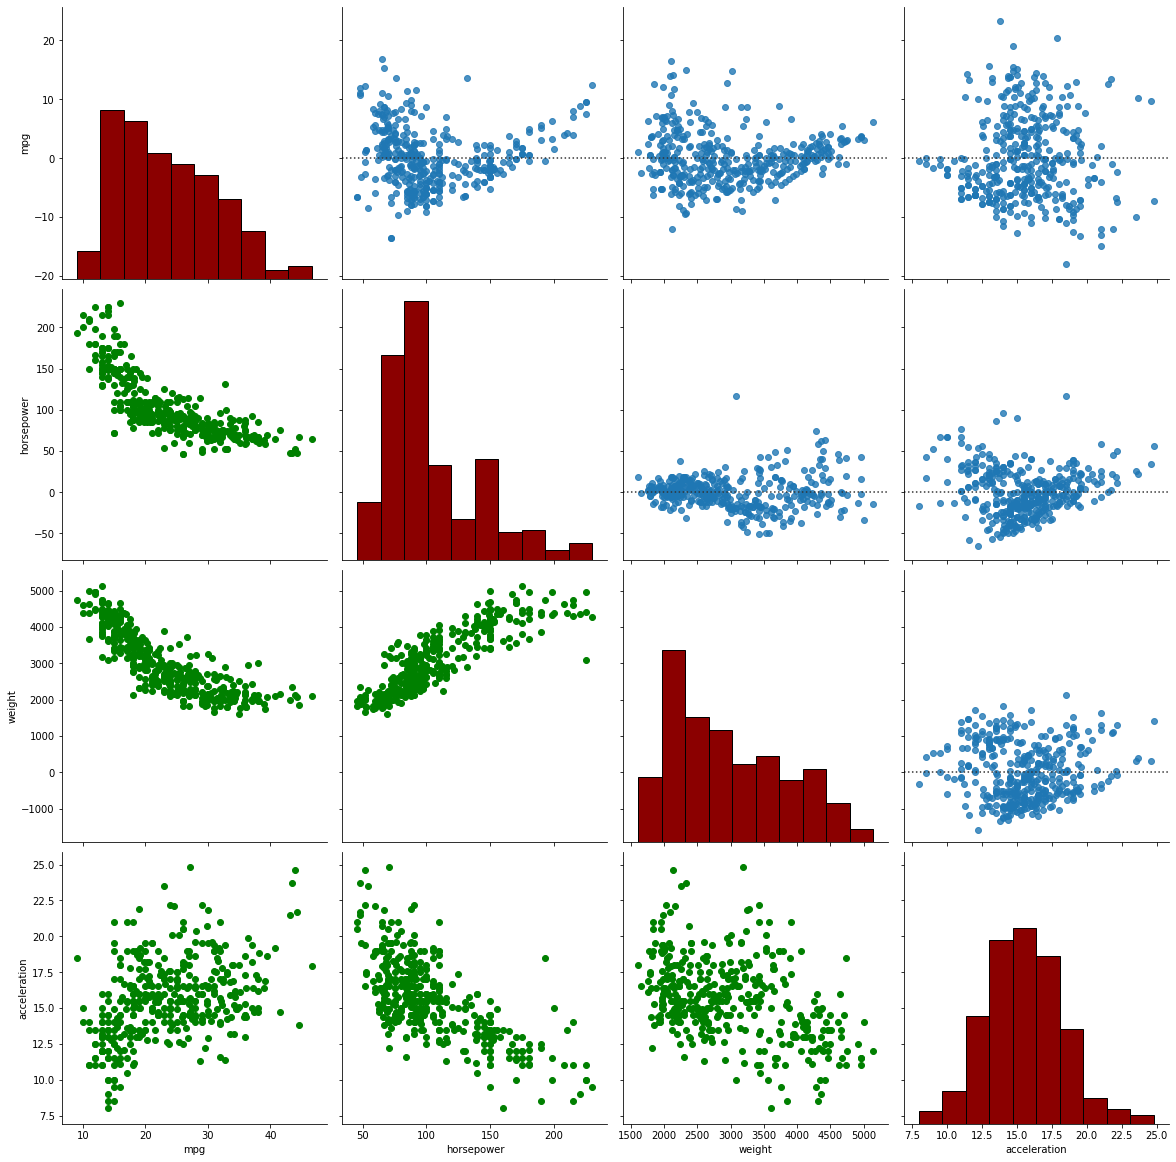

In [86]:
# HISTOGRAMS, SCATTERPLOTS AND RESIDUAL PLOTS
grid = sns.PairGrid(data= df, vars = ['mpg', 'horsepower',  'weight', 'acceleration'], size = 4)
grid = grid.map_upper(sns.residplot)
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
grid = grid.map_lower(plt.scatter, color='green')

7 out of 392 data points removed
Observed
        |  1970  |  1971  |  1972  |  1973  |  1974  |  1975  |  1976  |  1977  |  1978  |  1979  |  1980  |  1981  |  1982  | Total  | 
      4 |      7 |     12 |     14 |     11 |     15 |     12 |     15 |     14 |     17 |     12 |     23 |     20 |     27 |    199 | 
      6 |      4 |      8 |      0 |      8 |      6 |     12 |     10 |      5 |     12 |      6 |      2 |      7 |      3 |     83 | 
      8 |     18 |      7 |     13 |     20 |      5 |      6 |      9 |      8 |      6 |     10 |      0 |      1 |      0 |    103 | 
Total   |     29 |     27 |     27 |     39 |     26 |     30 |     34 |     27 |     35 |     28 |     25 |     28 |     30 |    103 | 

chi^2 = 99.564
p-val = 0.000
  df  = 24.000

Expected
   |  1970  |  1971  |  1972  |  1973  |  1974  |  1975  |  1976  |  1977  |  1978  |  1979  |  1980  |  1981  |  1982  | 
 4 | 14.990 | 13.956 | 13.956 | 20.158 | 13.439 | 15.506 | 17.574 | 13.956 | 18.091 | 14.473 | 

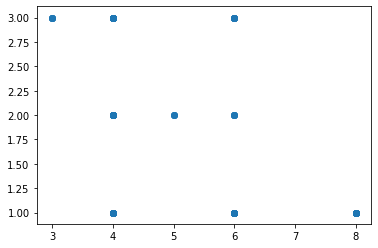

In [98]:
# CHI-SQUARE TEST
plt.scatter(df['cylinders'], df['origin'])
even_df = df[df['cylinders']%2!=1]
print(df.shape[0] - even_df.shape[0], 'out of', df.shape[0], 'data points removed')
from itertools import product

cylinders = sorted(even_df['cylinders'].unique())
years = sorted(even_df['model year'].unique())

# header row
print('Observed')
print('        | ', end='')
for year in list(years) + ['Total']: print(f'{year:^6} | ', end='')
print('\n' + '='*(9+9+9*len(years)))

table_obs = []
for cylinder in cylinders:
    table_obs.append([])
    print(f'{cylinder:7d} | ', end='')
    for year in years:
        table_obs[-1].append(np.sum(np.logical_and( even_df["cylinders"].values==cylinder, even_df["model year"].values==year )))
        print(f'{table_obs[-1][-1]:6d} | ', end='')
    print(f'{sum(table_obs[-1]):6d} | ', end='')
    print()

print(f'{"Total":7} | ', end='')
for i, year in enumerate(years):
    print(f'{sum(row[i] for row in table_obs):6d} | ', end='')
print(f'{sum(table_obs[-1]):6d} | ')
    
# chi^2, p-val, df
results = chi2_contingency(table_obs)
print('\nchi^2 = {:.3f}\np-val = {:.3f}\n  df  = {:.3f}\n'.format(*results[:3]))
print('Expected')
print('   | ', end='')
for year in years: print(f'{year:^6d} | ', end='')
print('\n' + '='*(4+9*len(years)))
for cylinder, row in zip(cylinders, results[3]):
    print(f'{cylinder:2d} | ', end='')
    for year, cell in zip(years, row):
        print(f'{cell:6.3f} | ', end='')
    print()

In [31]:
# LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(df[['horsepower', 'weight', 'acceleration']], df['mpg'])
prediction = model.predict(df[['horsepower', 'weight', 'acceleration']])
print('mpg = {0:.3f} {1:+.3f}*horsepower {2:+.3f}*weight {3:+.3f}*acceleration'.format(model.intercept_, *model.coef_))
print(f'r^2 = {r2_score(df["mpg"], prediction):.3f}')


mpg = 45.678 -0.047*horsepower -0.006*weight -0.002*acceleration
r^2 = 0.706


In [52]:
df['model year'].sample(5)

36     71
397    82
302    79
182    76
30     71
Name: model year, dtype: int64

In [57]:
df['cylinders'].sample(5)
l = list(df['cylinders'])
d = {}
for i in l:
    if i not in d:
        d[i] = 1
    else:
        d[i] += 1
d

{8: 103, 4: 199, 6: 83, 3: 4, 5: 3}